<a href="https://colab.research.google.com/github/alfredamboka/DeepTech5Yr/blob/main/mainProjectCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import math
import ee
#import geemap
#ee.Authenticate()
#ee.Initialize()




install and import geemap for convertion on js to py
Only applicable to Colab. In other cases or environment install normally and comment the cell below.

In [20]:
try:
    import geemap
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        print('geemap not found, installing via pip in Google Colab...')
        !pip install geemap --quiet
        import geemap
    else:
        print('geemap not found, please install via conda in your environment')

##J.S - P.y
Code to automatically convert GEE code from JavaScript to Python
- The cell below is used.
- Any js code provided will be converted to python.
- Write python code and js code in different cells

In [21]:
javascript_code = """
// Series of strings here!


"""

In [22]:
lines = geemap.js_snippet_to_py(
    javascript_code, add_new_cell=False,
    import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()
import geemap

Map = geemap.Map()

# Series of strings here!

Map


Testing Cell Bellow toconfirm if it is working.

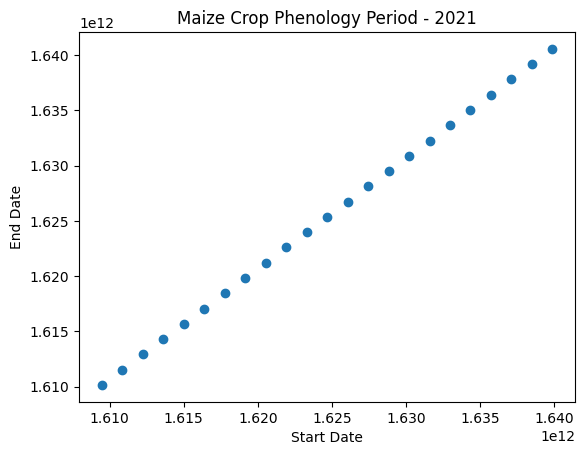

CSV file exported successfully.


In [23]:
import csv
import matplotlib.pyplot as plt

# Load MODIS EVI and Sentinel-2 datasets
modisCollection = ee.ImageCollection('MODIS/006/MOD13Q1')
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR')

# Filter for the desired year (2021 or 2020)
year = 2021

# Filter for Tana River county
countyName = 'Tana River'  # Change to the desired county name
counties = ee.FeatureCollection('FAO/GAUL/2015/level2')
county = counties.filter(ee.Filter.eq('ADM2_NAME', countyName))

# Filter MODIS EVI and Sentinel-2 datasets for the region and year
modisFiltered = modisCollection.filterBounds(county) \
    .filter(ee.Filter.calendarRange(year, year, 'year'))
sentinelFiltered = sentinelCollection.filterBounds(county) \
    .filter(ee.Filter.calendarRange(year, year, 'year'))

# Fusion of MODIS and Sentinel-2 data using the EVI band
def fusion(image):
    date = image.date()
    sentinelImage = sentinelFiltered.filterDate(date, date.advance(8, 'day')).median()

    return image.addBands(sentinelImage.select('B4').rename('Red')) \
        .addBands(sentinelImage.select('B8').rename('NIR'))

fusedCollection = modisFiltered.map(fusion)

# Calculate phenology period using EVI and NDVI thresholds
thresholdEVI = 2500
thresholdNDVI = 0.5

def calculate_phenology(image):
    evi = image.select('EVI')
    ndvi = image.expression('(NIR - Red) / (NIR + Red)', {
        'NIR': image.select('NIR'),
        'Red': image.select('Red')
    })

    eviMasked = evi.gt(thresholdEVI)
    ndviMasked = ndvi.gt(thresholdNDVI)

    start = eviMasked.multiply(ndviMasked).reduce(ee.Reducer.min()).rename('start')
    end = eviMasked.multiply(ndviMasked).reduce(ee.Reducer.max()).rename('end')

    return image.addBands(start).addBands(end)

phenologyPeriod = fusedCollection.map(calculate_phenology)

# Extract start and end dates of phenological periods
def extract_dates(image):
    startDate = ee.Date(image.get('system:time_start'))
    endDate = startDate.advance(8, 'day')

    return ee.Feature(None, {
        'start': startDate.millis(),
        'end': endDate.millis()
    })

phenologyDates = phenologyPeriod.map(extract_dates)

# Convert EE collection to a list for plotting
phenologyDatesList = phenologyDates.toList(phenologyDates.size())
startDates = phenologyDatesList.map(lambda f: ee.Feature(f).get('start')).getInfo()
endDates = phenologyDatesList.map(lambda f: ee.Feature(f).get('end')).getInfo()

# Plot the phenological periods
plt.scatter(startDates, endDates)
plt.title('Maize Crop Phenology Period - ' + str(year))
plt.xlabel('Start Date')
plt.ylabel('End Date')
plt.show()

# Export phenology dates to a CSV file
csv_data = [['start', 'end']]
for i in range(len(startDates)):
    csv_data.append([startDates[i], endDates[i]])

filename = 'Phenology_Dates_' + str(year) + '.csv'
with open(filename, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(csv_data)

print('CSV file exported successfully.')


## Datasets
- Load all the required dataset in this section.


In [24]:
#

## Batch Export
- Create a function that will enhance batch export of any output required.

In [25]:
#check end-to-end course solution to export bulk images.